In [1]:
import glob
import re
import xarray as xr
from cutshapefile import transform_from_latlon, rasterize
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.feature as cfeature
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

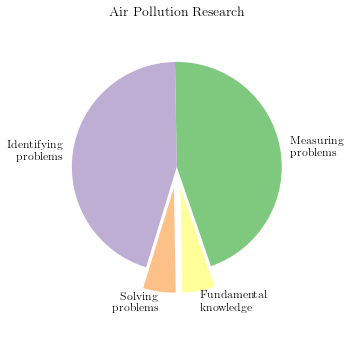

In [6]:
labels = 'Measuring\nproblems', 'Identifying\nproblems', 'Solving\nproblems', 'Fundamental\nknowledge'
sizes = [45, 45, 5, 5]
explode = (0, 0, 0.2, 0.2)
colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99']

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(sizes, explode=explode, labels=labels, startangle=-71, colors=colors, textprops={'fontsize': 12})
ax.axis('equal')
plt.title('Air Pollution Research', fontsize=14)
plt.tight_layout()
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/pie_chart_air_pollution_research.png', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [2]:
emission_files = glob.glob('/nfs/b0122/Users/earlacoa/emissions/EDGAR-HTAP2_MEIC2015/MOZART/*nc')
emission_files = [emission_file for emission_file in emission_files if 'CH4' not in emission_file]

In [3]:
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')
shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]

In [16]:
emissions = {}

for emission_file in emission_files:
    specie = re.findall(r'MEIC2015_[A-Z]*[a-z]*[0-9]*.[A-Z]*[0-9]*[A-Z]*', emission_file)[0].split('_')[1]
    
    with xr.open_dataset(emission_file) as ds:
        if specie != 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'ENE']:
                ds_annual = ds[f'emis_{sector.lower()}'].sum(dim='time')
                
                ds_annual['shapefile'] = rasterize(shapes, ds_annual.coords, longitude='lon', latitude='lat') 
                ds_annual['shapefile'] = ds_annual.shapefile.where(cond=ds_annual.shapefile!=0, other=1)
                ds_annual_cropped = ds_annual.where(cond=ds_annual.shapefile==1, other=np.nan)
                
                emissions.update({f'{sector}_{specie}': ds_annual_cropped})
        elif specie == 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'AGR', 'ENE']:
                ds_annual = ds[f'emis_{sector.lower()}'].sum(dim='time')
                
                ds_annual['shapefile'] = rasterize(shapes, ds_annual.coords, longitude='lon', latitude='lat') 
                ds_annual['shapefile'] = ds_annual.shapefile.where(cond=ds_annual.shapefile!=0, other=1)
                ds_annual_cropped = ds_annual.where(cond=ds_annual.shapefile==1, other=np.nan)
                
                emissions.update({f'{sector}_{specie}': ds_annual_cropped})

In [17]:
emissions_all = {}

for emission_file in emission_files:
    specie = re.findall(r'MEIC2015_[A-Z]*[a-z]*[0-9]*.[A-Z]*[0-9]*[A-Z]*', emission_file)[0].split('_')[1]
    
    with xr.open_dataset(emission_file) as ds:
        if specie != 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'ENE']:
                ds_annual = ds[f'emis_{sector.lower()}'].sum(dim='time')
                              
                emissions_all.update({f'{sector}_{specie}': ds_annual})
        elif specie == 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'AGR', 'ENE']:
                ds_annual = ds[f'emis_{sector.lower()}'].sum(dim='time')
                
                emissions_all.update({f'{sector}_{specie}': ds_annual})

In [18]:
lat = ds.lat.values
lon = ds.lon.values

xx, yy = np.meshgrid(lon, lat)

In [19]:
titles = {'BC': 'BC', 'OC': 'OC', 'PM2.5': 'PM$_{2.5}$', 'PM10': 'PM$_{10}$', 'CO': 'CO', 'NH3': 'NH$_{3}$', 'NOx': 'NO$_{X}$', 'SO2': 'SO$_{2}$', 'VOC': 'VOC'}

In [37]:
levels_sectors_species = {
    'RES_BC': np.linspace(0, 1e-10, 11),
    'IND_BC': np.linspace(0, 1e-10, 11),
    'TRA_BC': np.linspace(0, 1e-10, 11),
    'ENE_BC': np.linspace(0, 1e-10, 11),
    'RES_OC': np.linspace(0, 1e-10, 11),
    'IND_OC': np.linspace(0, 1e-10, 11),
    'TRA_OC': np.linspace(0, 1e-10, 11),
    'ENE_OC': np.linspace(0, 1e-10, 11),
    'RES_PM2.5': np.linspace(0, 1e-9, 11),
    'IND_PM2.5': np.linspace(0, 1e-9, 11),
    'TRA_PM2.5': np.linspace(0, 1e-9, 11),
    'ENE_PM2.5': np.linspace(0, 1e-9, 11),
    'RES_PM10': np.linspace(0, 1e-9, 11),
    'IND_PM10': np.linspace(0, 1e-9, 11),
    'TRA_PM10': np.linspace(0, 1e-9, 11),
    'ENE_PM10': np.linspace(0, 1e-9, 11),    
    'RES_CO': np.linspace(0, 1e-8, 11),
    'IND_CO': np.linspace(0, 1e-8, 11),
    'TRA_CO': np.linspace(0, 1e-8, 11),
    'ENE_CO': np.linspace(0, 1e-8, 11),
    'RES_NH3': np.linspace(0, 1e-9, 11),
    'IND_NH3': np.linspace(0, 1e-9, 11),
    'TRA_NH3': np.linspace(0, 1e-9, 11),
    'AGR_NH3': np.linspace(0, 1e-9, 11),
    'RES_NOx': np.linspace(0, 1e-9, 11),
    'IND_NOx': np.linspace(0, 1e-9, 11),
    'TRA_NOx': np.linspace(0, 1e-9, 11),
    'ENE_NOx': np.linspace(0, 1e-9, 11),
    'RES_SO2': np.linspace(0, 1e-9, 11),
    'IND_SO2': np.linspace(0, 1e-9, 11),
    'TRA_SO2': np.linspace(0, 1e-9, 11),
    'ENE_SO2': np.linspace(0, 1e-9, 11),
    'RES_VOC': np.linspace(0, 1e-8, 11),
    'IND_VOC': np.linspace(0, 1e-8, 11),
    'TRA_VOC': np.linspace(0, 1e-8, 11),
    'ENE_VOC': np.linspace(0, 1e-8, 11),
}

In [21]:
def make_plot(index, emissions, sector, specie, region):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    plt.annotate(r'\textbf{(' + chr(index + 97) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    if region == 'China':
        shape_feature = ShapelyFeature(
            Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp').geometries(),                             
            ccrs.PlateCarree(), 
            facecolor='none'
        )
        shape2_feature = ShapelyFeature(
            Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp').geometries(),                             
            ccrs.PlateCarree(), 
            facecolor='none'
        )
        ax.patch.set_visible(False)
        ax.spines['geo'].set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape2_feature, edgecolor='black', linewidth=0.3)
    elif region == 'all':
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, edgecolor='black')
    
    if specie != 'VOC':
        emission = emissions[f'{sector}_{specie}']
    else:
        for number_voc, individual_voc in enumerate(['CH3OH', 'CH3CHO', 'C2H6', 'XYLENE', 'C2H5OH', 'C3H8', 'C3H6', 'MEK', 'BENZENE', 'BIGALK', 'C2H4', 'BIGENE', 'CH3COCH3', 'CH2O', 'TOLUENE']):
            if number_voc == 0:
                emission = emissions[f'{sector}_{individual_voc}']
            else:
                emission += emissions[f'{sector}_{individual_voc}']
    
    cmap = 'viridis'
    levels = levels_sectors_species[f'{sector}_{specie}']
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    
    im = ax.contourf(xx, yy, emission, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend='max')
    
    cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels[:-1], shrink=0.50)
    cb.set_label('Annual sum of emissions of ' + titles[specie] + ',\n in 2015\n($kg$ $m^{-2}$ $s^{-1}$)', size=14)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'{sector}')

KeyError: 'AGR_CH3OH'

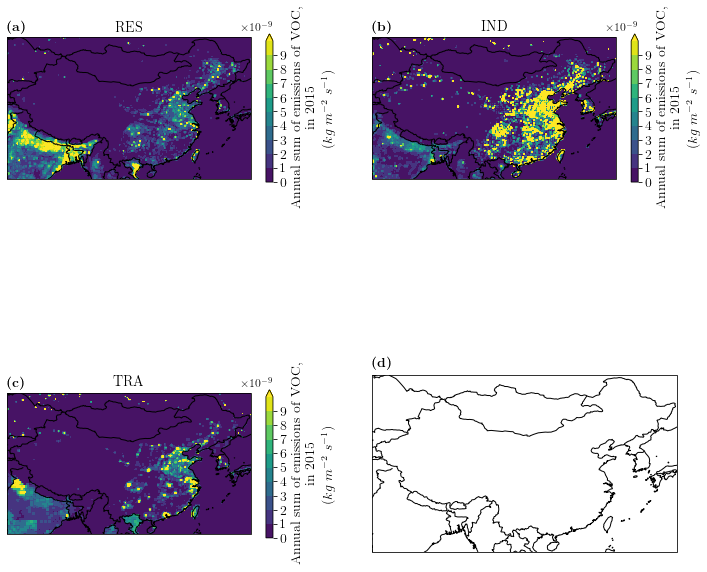

In [38]:
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)

specie = 'VOC'
sectors = ['RES', 'IND', 'TRA', 'ENE']
for index, sector in enumerate(sectors):
    make_plot(index, emissions_all, sector, specie, 'all')

gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_jan_china_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_jan_china_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

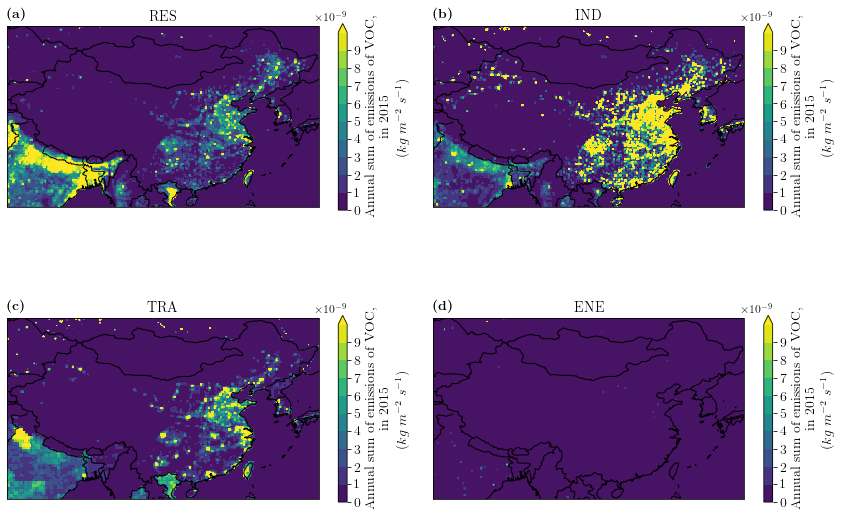

In [39]:
region = 'all'

for specie in ['VOC']: # ['BC', 'OC', 'PM2.5', 'PM10', 'CO', 'NH3', 'NOx', 'SO2', 'VOC']
    if specie != 'NH3' and specie != 'VOC':
        sectors = ['RES', 'IND', 'TRA', 'ENE']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()
        
    elif specie == 'NH3':
        sectors = ['RES', 'IND', 'TRA', 'AGR']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()
        
    elif specie == 'VOC':
        sectors = ['RES', 'IND', 'TRA', 'ENE']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()